# Natural Gradient for 1D Gaussian

### Parameter space of 1D Gaussian
1D Gaussian is defined by mean, $\mu$ and variance, $\sigma^2$. We will use $\mu$ and $\log \sigma$ as this will ensure $\sigma$ is always positive. Let's define some functions and visualize some properties of the data points and the parameter space.

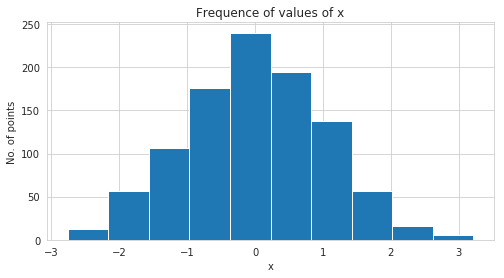

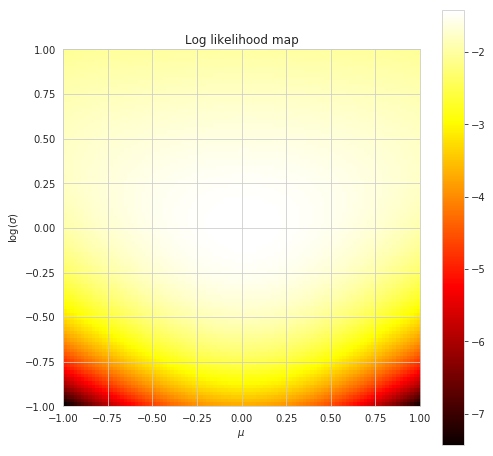

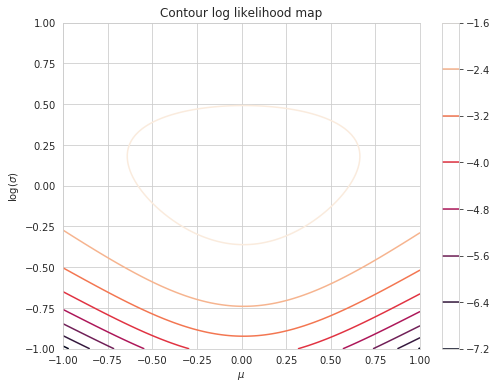

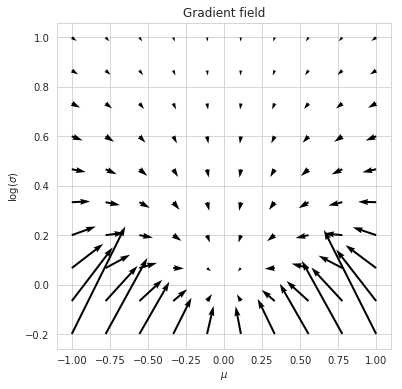

In [240]:
# parameterize as mu and log_sigma

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import copy

sns.set_style('whitegrid')

numPts = 1000
X = np.random.normal(0,1,size=numPts)

def gauss(mu, logSigma):
    sigma = np.exp(logSigma)
    single_gauss = (1/(np.sqrt(2*np.pi)*sigma)) * np.exp(-0.5*((X-mu)**2/(sigma**2)))
    return np.prod(single_gauss, axis = -1, keepdims=False)

def logGauss(mu, logSigma):
    sigma = np.exp(logSigma)
    single_log_gauss = np.log(1/(np.sqrt(2*np.pi)*sigma)) - 0.5*((X-mu)**2/(sigma**2))
    return np.mean(single_log_gauss, axis = -1 ,keepdims = False)

def diff(mu, logSigma):
    sigma = np.exp(logSigma)
    diffMu = (X-mu)/(sigma**2)
    diffSigma = (-(1/sigma) + ((X-mu)**2)/(sigma**3))
    diffLogSigma = diffSigma/sigma    
    return np.mean(diffMu, axis = -1), np.mean(diffLogSigma, axis = -1)


def diff_and_F(mu, logSigma): # assume only one mu and logSigma will be passed
    sigma = np.exp(logSigma)
    diffMu = (X-mu)/(sigma**2)
    diffLogSigma = (-1 + ((X-mu)**2)/(sigma**2))
    
    mat = np.stack([diffMu, diffLogSigma])  
#     print('min max in mat', np.min(mat), np.max(mat))
    F = (1/numPts)*np.matmul(mat, mat.T)
    return np.mean(diffMu, axis = -1), np.mean(diffLogSigma, axis = -1), F

mu, logSigma = np.meshgrid(np.linspace(-1,1,100), np.linspace(-1,1,100))
logLikeMap = logGauss(mu[:,:,None], logSigma[:,:,None])

plt.figure(figsize=(8,4))
plt.hist(X)
plt.title('Frequence of values of x')
plt.xlabel('x')
plt.ylabel('No. of points')
plt.show()

plt.figure(figsize=(8,8))
plt.imshow(logLikeMap, origin='lower', extent=[-1,1,-1,1], cmap='hot')
plt.colorbar()
plt.title('Log likelihood map')
plt.xlabel('$\mu$')
plt.ylabel('$\log(\sigma)$')
plt.show()

plt.figure(figsize=(8,6))
plt.contour(logLikeMap, extent=[-1,1,-1,1])
plt.colorbar()
plt.title('Contour log likelihood map')
plt.xlabel('$\mu$')
plt.ylabel('$\log(\sigma)$')
plt.show()

mu, logSigma = np.meshgrid(np.linspace(-1,1,10), np.linspace(-0.2,1,10))
diffMu, diffSigma = diff(mu[:,:,None], logSigma[:,:,None])
fig, ax = plt.subplots(figsize=(6,6))
q = ax.quiver(mu, logSigma, diffMu, diffSigma)
plt.title('Gradient field')
plt.xlabel('$\mu$')
plt.ylabel('$\log(\sigma)$')
plt.show()

## Simple Gradient Ascent

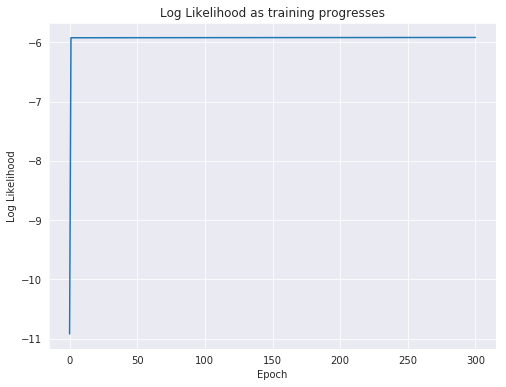

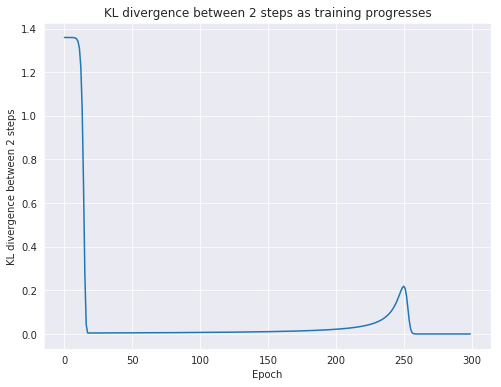

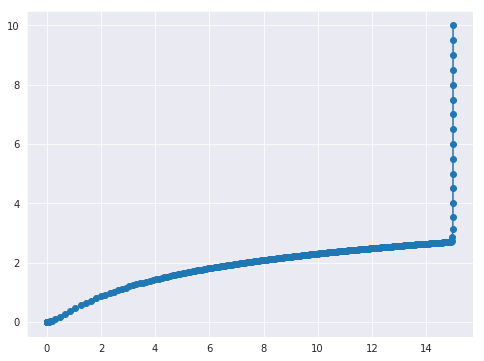

In [241]:
sns.set_style('darkgrid')

def draw_trace(trace_x, trace_y):
    xmin, xmax = np.min(trace_x), np.max(trace_x)
    ymin, ymax = np.min(trace_y), np.max(trace_y)
    plt.figure(figsize=(8,6))
    plt.plot(trace_x, trace_y, marker="o")
    plt.title('$\mu$ & $\log(\sigma)$ as as training progresses')
    plt.xlabel('$\mu$')
    plt.ylabel('$\log(\sigma)$')
    plt.show()

def plot_info(likelihoodArr, name):
    plt.figure(figsize=(8,6))
    plt.plot(likelihoodArr)
    plt.title('{} as training progresses'.format(name))
    plt.xlabel('Epoch')
    plt.ylabel(name)    

def GaussianKL(mu1, logSigma1, mu2, logSigma2):
    sigma1, sigma2 = np.exp(logSigma1), np.exp(logSigma2)
    return logSigma1-logSigma2 + (sigma1**2 + (mu1-mu2)**2)/(2 * sigma2**2) - 0.5

def draw_trace(trace_x, trace_y):
    xmin, xmax = np.min(trace_x), np.max(trace_x)
    ymin, ymax = np.min(trace_y), np.max(trace_y)
    plt.figure(figsize=(8,6))
    plt.plot(trace_x, trace_y, marker="o")
    plt.show()

# Natural gradient
epochs = 300
lr = 5e-1
mu, logSigma = 15,10  # initialization

traceMu, traceLogSigma = [mu], [logSigma]
logLikeArr = [logGauss(mu,logSigma)]
KLArr = []

for e in range(epochs):
    muOld, logSigmaOld = copy.copy(mu), copy.copy(logSigma) 
    diffMu, diffLogSigma, F = diff_and_F(mu, logSigma)
    mu += lr * diffMu
    logSigma += lr * diffLogSigma
    traceMu.append(mu)
    traceLogSigma.append(logSigma)
    logLikeArr.append(logGauss(mu,sigma))
    KLArr.append(GaussianKL(muOld, logSigmaOld, mu, logSigma))
    
plot_info(logLikeArr, 'Log Likelihood')
plot_info(KLArr, 'KL divergence between 2 steps')
draw_trace(traceMu, traceLogSigma)



## Natural Gradient Ascent

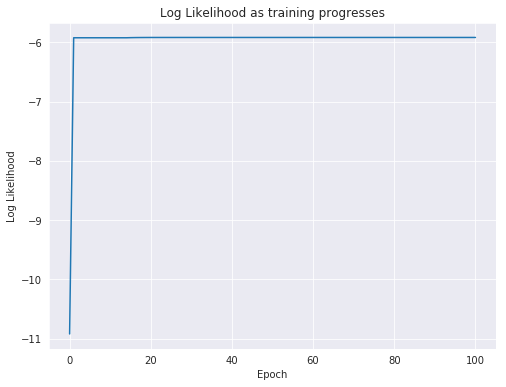

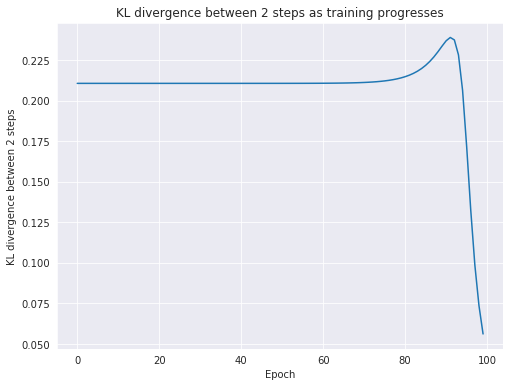

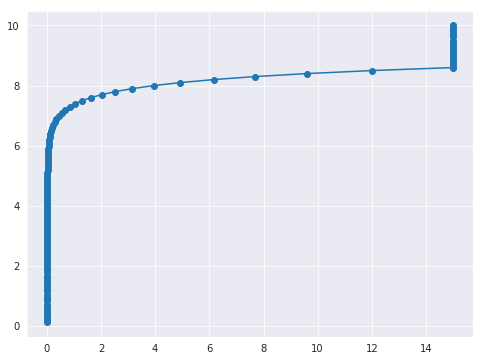

In [242]:


# Natural gradient
epochs = 100
lr = 1e-1
mu, logSigma = 15,10  # initialization

traceMu, traceLogSigma = [mu], [logSigma]
logLikeArrNatural = [logGauss(mu,logSigma)]
KLArrNatural = []
for e in range(epochs):
    muOld, logSigmaOld = copy.copy(mu), copy.copy(logSigma) 
    diffMu, diffLogSigma, F = diff_and_F(mu, logSigma)
    FInv = np.linalg.pinv(F)
    grad = np.array([diffMu, diffLogSigma]).reshape((2,1))
    naturalGrad = np.matmul(FInv, grad)
    naturalDiffMu, naturalDiffLogSigma = naturalGrad[0,0], naturalGrad[1,0]
    mu += lr * naturalDiffMu
    logSigma += lr * naturalDiffLogSigma
    traceMu.append(mu)
    traceLogSigma.append(logSigma)
    logLikeArrNatural.append(logGauss(mu,sigma))
    KLArrNatural.append(GaussianKL(muOld, logSigmaOld, mu, logSigma))


plot_info(logLikeArrNatural, 'Log Likelihood')
plot_info(KLArrNatural, 'KL divergence between 2 steps')
draw_trace(traceMu, traceLogSigma)